In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import math
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
from scipy import stats


dat_path = os.getcwd()[:-12] + 'Data/'
fig_path = os.getcwd()[:-4] + 'figures/preliminary/'
generated_dat_path = os.getcwd()[:-12] + 'Data/generated_data/'

text_font = 30

In [3]:
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [4]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [5]:
def count_streaks_aggregated(sequence, streak_type):
    """
    Count and aggregate the lengths of streaks (either hot or cold) of a certain length or longer.

    :param sequence: Sequence of game outcomes (1s and 0s).
    :param streak_type: Type of streak to count ('hot' for wins, 'cold' for losses).
    :return: A dictionary where keys are minimum streak lengths and values are aggregated counts.
    """
    aggregated_streaks = {}
    current_streak = 0
    streak_value = 1 if streak_type == 'hot' else 0

    for outcome in sequence:
        if outcome == streak_value:
            current_streak += 1
        elif current_streak > 0:
            for length in range(1, current_streak + 1):
                aggregated_streaks[length] = aggregated_streaks.get(length, 0) + 1
            current_streak = 0

    # If the sequence ends with a streak, count it
    if current_streak > 0:
        for length in range(1, current_streak + 1):
            aggregated_streaks[length] = aggregated_streaks.get(length, 0) + 1

    return aggregated_streaks

In [6]:
def best_perform(player_data_array, num_best):
    
    hot_streak = []
    original_indices = np.arange(len(player_data_array[:,0]))

    while len(hot_streak) < num_best:
        
        # check if there are non-nan values
        if np.sum(np.isnan(player_data_array[:,0])) == len(player_data_array[:,0]):
            best_row = num_best - len(player_data_array[:,0])

        else:
            # Identifying the maximum number of runs scored or maximum wickets taken
            max_perform = np.nanmax(player_data_array[:,0])

            # Filtering the rows where the player scored the maximum runs or took the maximum wickets
            max_perform_inds = np.where(player_data_array[:, 0] == max_perform)[0]

            # If multiple instances, choose the one with the lowest 'bat_balls' (for runs) or 'bowl_runs' (for wickets)
            if len(max_perform_inds) > 1:
                best_row = max_perform_inds[np.argmin(player_data_array[max_perform_inds, 1])]
            else:
                try:
                    best_row = max_perform_inds[0]
                except:
                    best_row = max_perform_inds

        # Append the original index of the best performance
        hot_streak.append(original_indices[best_row])

        # Remove the row with the best performance
        player_data_array = np.delete(player_data_array, best_row, axis=0)
        original_indices = np.delete(original_indices, best_row)

    return hot_streak

In [7]:
def best_perform_relative(player_data_array, num_best):
    
    hot_streak = []
    original_indices = np.arange(len(player_data_array[:,0]))

    while len(hot_streak) < num_best:
        # Identifying the maximum number of runs scored or maximum wickets taken
        max_perform = np.nanmax(player_data_array[:,0])

        # Filtering the rows where the player scored the maximum runs or took the maximum wickets
        max_perform_inds = np.where(player_data_array[:, 0] == max_perform)[0]

        # If multiple instances, choose the one with the lowest 'bat_balls' (for runs) or 'bowl_runs' (for wickets)
        if len(max_perform_inds) > 1:
            best_row = max_perform_inds[np.argmin(player_data_array[max_perform_inds, 1])]
        else:
            best_row = max_perform_inds[0]

        # Append the original index of the best performance
        hot_streak.append(original_indices[best_row]/len(player_data_array[:,0]))

        # Remove the row with the best performance
        player_data_array = np.delete(player_data_array, best_row, axis=0)
        original_indices = np.delete(original_indices, best_row)

    return hot_streak

In [8]:
def random_impact_rule_data(min_career, norm_quant, category, rand_num):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'])

    randomized, data = [], []

    for player in tqdm(players_list):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')
        temp_df = temp_df.reset_index(drop=True)

        if category == 'bat':
            if temp_df['batsmen'].sum() > min_career:
                dat_array = temp_df[['renormalized_bat_run', 'bat_balls']].values
                data.append(best_perform(dat_array, 3))
                
                for r in range(rand_num):
                    rnd_array = np.random.permutation(dat_array)
                    randomized.append(best_perform(rnd_array, 3))

                    
        elif category == 'bowl':
            if temp_df['bowler'].sum() > min_career:
                dat_array = temp_df[['bowl_wickets', 'bowl_runs']].values
                data.append(best_perform(dat_array, 3))
                
                for r in range(rand_num):
                    rnd_array = np.random.permutation(dat_array)
                    randomized.append(best_perform(rnd_array, 3))

    with open(generated_dat_path + f'random_impact_rule_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'wb') as f:
        pickle.dump([data, randomized], f)

# random_impact_rule_data(min_career=25, norm_quant='Runs', category='bat', rand_num=5000)
# random_impact_rule_data(min_career=25, norm_quant='Runs', category='bowl', rand_num=5000)

In [9]:
def hot_streak_data(min_career, norm_quant, category, rand_num):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'])

    randomized, data = [], []

    for player in tqdm(players_list):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')
        temp_df = temp_df.reset_index(drop=True)

        if category == 'bat':
            if temp_df['batsmen'].sum() > min_career:
                dat_array = temp_df[['renormalized_bat_run', 'bat_balls']].values
                data.append(best_perform_relative(dat_array, 3))
                
                for r in range(rand_num):
                    rnd_array = np.random.permutation(dat_array)
                    randomized.append(best_perform_relative(rnd_array, 3))

                    
        elif category == 'bowl':
            if temp_df['bowler'].sum() > min_career:
                dat_array = temp_df[['bowl_wickets', 'bowl_runs']].values
                data.append(best_perform_relative(dat_array, 3))
                
                for r in range(rand_num):
                    rnd_array = np.random.permutation(dat_array)
                    randomized.append(best_perform_relative(rnd_array, 3))

    with open(generated_dat_path + f'hot_streak_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'wb') as f:
        pickle.dump([data, randomized], f)

# hot_streak_data(min_career=25, norm_quant='Runs', category='bat', rand_num=5000)
# hot_streak_data(min_career=25, norm_quant='Runs', category='bowl', rand_num=5000)

In [10]:
def absolute_random_impact_rule_plot(min_career, norm_quant, rand_num, nbins):

    category_list = ['bat', 'bowl']
    color_list = ['#398676','#E96659','#DE9E37']

    fig, ax = plt.subplots(1,1,figsize=(8, 5))

    for i in range(1):

        _dat, _rnd = [], []

        for category in category_list:

            with open(generated_dat_path + f'random_impact_rule_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'rb') as f:
                data, randomized = pickle.load(f)

            data = np.array(data)
            randomized = np.array(randomized)

            _dat.append(data[:,i])
            _rnd.append(randomized[:,i])

        _dat = [item for sublist in _dat for item in sublist]
        _rnd = [item for sublist in _rnd for item in sublist]
            
        y, bincenters = np.histogram(_dat, bins=nbins, density=True)    
        y_rand, bincenters_rnd = np.histogram(_rnd, bins=nbins, density=True)
        
        ax.plot(bincenters[:-1], y, linestyle=None, linewidth=0, color= '#d92e80', marker='o', markersize=15, label=f'data')

        # first = '*'*(i+1)
        # if i == 0:
        ax.plot(bincenters_rnd[:-1], y_rand, color='black', linewidth=3, linestyle='--', label='null-model', zorder=100)

    ax.set_xlabel(r'$N*$', fontsize=text_font)
    ax.set_ylabel(r'$P(N*)$', fontsize=text_font)

    ax.set_yscale('log')

    axis_decor(ax, text_font, 10, 5, 3)
    ax.legend(fontsize=text_font-2, loc='lower left', frameon=False, bbox_to_anchor=(-0.01, -0.01, 0.2, 0.2), labelspacing=0.3, handletextpad=0.2, columnspacing=0.1)
    ax.set_xlim(-20,480)
    ax.set_ylim(7e-6, 5e-2)
    ax.set_yticks([1e-4, 1e-2])

    plt.tight_layout()
    plt.savefig(fig_path + f'absolute_random_impact_rule_min_career_{min_career}_renorm_{norm_quant}_rnd_num_{rand_num}.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close
        
# absolute_random_impact_rule_plot(min_career=25, norm_quant='Runs', rand_num=5000, nbins=17)

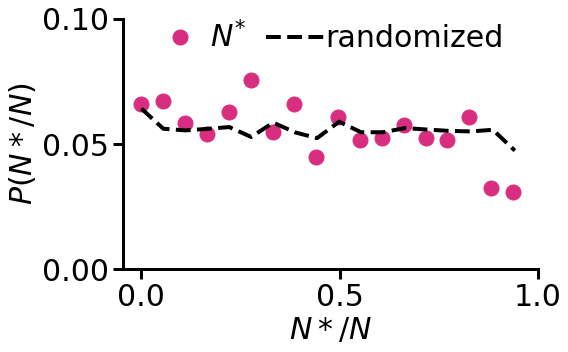

In [23]:
def relative_random_impact_rule_plot(min_career, norm_quant, rand_num, nbins):

    category_list = ['bat', 'bowl']

    fig, ax = plt.subplots(1,1,figsize=(8, 5))

    _dat, _rnd = [], []

    for category in category_list:

        with open(generated_dat_path + f'hot_streak_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'rb') as f:
            data, randomized = pickle.load(f)

        data = np.array(data)
        randomized = np.array(randomized)

        _dat.append(data[:,0])
        _rnd.append(randomized[:,0])

    _dat = [item for sublist in _dat for item in sublist]
    _rnd = [item for sublist in _rnd for item in sublist]
        
    y, bincenters = np.histogram(_dat, bins=nbins, density=False)    
    y_rand, bincenters_rnd = np.histogram(_rnd, bins=nbins, density=False)

    ax.plot(bincenters[:-1], y/len(_dat), color='#d92e80', linewidth=0, marker='o', markersize=15, label=f'$N^{{*}}$')
    ax.plot(bincenters_rnd[:-1], y_rand/len(_rnd), color='black', linewidth=4, linestyle='--', label='randomized')

    ax.set_xlabel(r'$N*/N$', fontsize=text_font)
    ax.set_ylabel(r'$P(N*/N)$', fontsize=text_font)

    ax.set_ylim(0.0, 0.1)
    ax.set_xticks([0, 0.5, 1.0], fontsize=text_font)
    ax.set_yticks([0, 0.05, 0.1], fontsize=text_font)

    axis_decor(ax, text_font, 10, 5, 3)

    ax.legend(fontsize=text_font, loc='upper left', frameon=False, bbox_to_anchor=(0, 0.9, 0.2, 0.2), ncol=2, labelspacing=0, handletextpad=0, columnspacing=0.65)
    # ax.set_title(f'nbins = {nbins}', fontsize=text_font)

    plt.tight_layout()
    plt.savefig(fig_path + f'relative_random_impact_rule_min_career_{min_career}_renorm_{norm_quant}_rnd_num_{rand_num}.pdf', format='pdf', dpi=300)
    plt.savefig(fig_path + f'relative_random_impact_rule_min_career_{min_career}_renorm_{norm_quant}_rnd_num_{rand_num}.png', format='png', dpi=300)
    plt.show()
    plt.close

# for i in range(5, 25):
relative_random_impact_rule_plot(min_career=25, norm_quant='Runs', rand_num=5000, nbins=18)

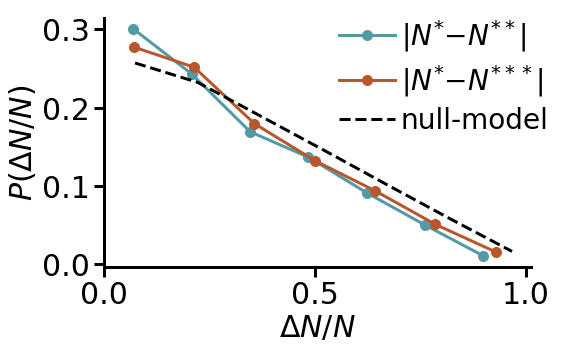

In [24]:
def hot_streak_plot(min_career, norm_quant, rand_num, nbins):

    category_list = ['bat', 'bowl']

    # color_list = ['#c3a0e5', '#70cc14', '#89c9e5']
    color_list = ['#5499A6','#B8572B']

    fig, ax = plt.subplots(1,1,figsize=(8, 5))

    for col, (i, j) in zip(color_list,[(0,1), (0,2)]): #, (1,2)

        _dat, _rnd = [], []

        for category in category_list:

            with open(generated_dat_path + f'hot_streak_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'rb') as f:
                data, randomized = pickle.load(f)

            data = np.array(data)
            randomized = np.array(randomized)

            _dat.append(np.abs(data[:,i]-data[:,j]))
            _rnd.append(np.abs(randomized[:,i]-randomized[:,j]))

        _dat = [item for sublist in _dat for item in sublist]
        _rnd = [item for sublist in _rnd for item in sublist]
            
        y, bincenters = np.histogram(_dat, bins=nbins, density=False)    
        y_rand, bincenters_rnd = np.histogram(_rnd, bins=nbins, density=False)

        first = '*'*(i+1)
        second = '*'*(j+1)
        ## the bin centres are midpoints of the bins
        bincenters = 0.5*(bincenters[1:] + bincenters[:-1])


        ax.plot(bincenters, (y/len(_dat)), color=col, linewidth=3, marker='o', markersize=10, label=f'|$N^{{{first}}}$'+'$-$'+f'$N^{{{second}}}$|')
    
    bincenters_rnd = 0.5*(bincenters_rnd[1:] + bincenters_rnd[:-1])
    ax.plot(bincenters_rnd, y_rand/len(_rnd), color='black', linewidth=3, linestyle='--', label='null-model', zorder=100)

    ax.set_xlabel(r'$ \Delta N/N$', fontsize=text_font)
    ax.set_ylabel(r'$P(\Delta N/N)$', fontsize=text_font)

    # ax.set_ylim(-0.01, 0.15)

    ax.set_xticks([0, 0.5, 1.0], fontsize=text_font)
    axis_decor(ax, text_font, 10, 5, 3)

    ax.legend(fontsize=text_font-2, loc='upper right', frameon=False, bbox_to_anchor=(0.9, 0.9, 0.2, 0.2), labelspacing=0.3, handletextpad=0.2)
    # ax.set_title(f'nbins {nbins}', fontsize=text_font)

    plt.tight_layout()
    plt.savefig(fig_path + f'hot_streak_min_career_{min_career}_renorm_{norm_quant}_rnd_num_{rand_num}.pdf', format='pdf', dpi=300)
    plt.savefig(fig_path + f'hot_streak_min_career_{min_career}_renorm_{norm_quant}_rnd_num_{rand_num}.png', format='png', dpi=300)
    plt.show()
    plt.close()


# for i in range(5, 30):
hot_streak_plot(min_career=25, norm_quant='Runs', rand_num=5000, nbins=7)

In [13]:
def individual_top(category):
    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    if category == 'bat':

        player_runs = odi_final.groupby('player_name')['renormalized_bat_run'].sum().reset_index()

        player_runs = player_runs.sort_values(by='renormalized_bat_run', ascending=False)

        for ind_player in player_runs['player_name'][:5]:
            temp_df = odi_final[odi_final['player_name'] == ind_player]
            dat_array = temp_df[['renormalized_bat_run', 'bat_balls']].values
            print(ind_player, best_perform(dat_array, 3), best_perform_relative(dat_array, 3))

    elif category == 'bowl':

        player_wickets = odi_final.groupby('player_name')['bowl_wickets'].sum().reset_index()

        player_wickets = player_wickets.sort_values(by='bowl_wickets', ascending=False)

        for ind_player in player_wickets['player_name'][:5]:
            temp_df = odi_final[odi_final['player_name'] == ind_player]
            dat_array = temp_df[['bowl_wickets', 'bowl_runs']].values
            print(ind_player, best_perform(dat_array, 1), best_perform_relative(dat_array, 1))

individual_top(category='bat')
# individual_top(category='bowl')

Sachin Tendulkar [428, 218, 421] [0.9511111111111111, 0.48552338530066813, 0.9397321428571429]
Kumar Sangakkara [337, 207, 329] [0.8618925831202046, 0.5307692307692308, 0.8457583547557841]
Ricky Ponting [247, 167, 49] [0.6675675675675675, 0.45257452574525747, 0.1331521739130435]
Sanath Jayasuriya [212, 358, 357] [0.48623853211009177, 0.8229885057471265, 0.8225806451612904]
Virat Kohli [82, 199, 261] [0.2971014492753623, 0.7236363636363636, 0.9525547445255474]


In [14]:
def individual_hot(category):
    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    if category == 'bat':
        bat_runs = odi_final.sort_values(by='renormalized_bat_run', ascending=False)

        for ind_player in bat_runs['player_name'][:5]:
            temp_df = odi_final[odi_final['player_name'] == ind_player]
            dat_array = temp_df[['renormalized_bat_run', 'bat_balls']].values

            hot_streak_data = best_perform(dat_array, 3)
            print(ind_player,hot_streak_data[0],hot_streak_data[1], (hot_streak_data[1]-hot_streak_data[0]), (hot_streak_data[1]-hot_streak_data[0])/len(temp_df) )

            
        
    elif category == 'bowl':
        bowl_wickets = odi_final.sort_values(by='bowl_wickets', ascending=False)

        for ind_player in bowl_wickets['player_name'][:5]:
            temp_df = odi_final[odi_final['player_name'] == ind_player]
            dat_array = temp_df[['bowl_wickets', 'bowl_runs']].values

            hot_streak_data = best_perform(dat_array, 3)
            print(ind_player, (hot_streak_data[1]-hot_streak_data[0]), (hot_streak_data[1]-hot_streak_data[0])/len(temp_df) )

individual_hot(category='bat')
individual_hot(category='bowl')    

Rohit Sharma 121 105 -16 -0.06451612903225806
Viv Richards 73 131 58 0.31351351351351353
Virender Sehwag 231 220 -11 -0.04526748971193416
Martin Guptill 101 68 -33 -0.17098445595854922
Ishan Kishan 9 7 -2 -0.07692307692307693
Chaminda Vaas 40 0.12658227848101267
Imran Tahir 28 0.2692307692307692
Waqar Younis -191 -0.7374517374517374
Ali Khan -7 -0.4666666666666667
Shahid Afridi -81 -0.2066326530612245
